🧹 Dropping non-numeric columns:
['top_states']
✅ Final training shape: (5410, 41)
✅ Data balanced with SMOTE
✅ Final model trained

=== CLASSIFICATION REPORT ===

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       981
           1       0.60      0.70      0.65       101

    accuracy                           0.93      1082
   macro avg       0.78      0.83      0.80      1082
weighted avg       0.93      0.93      0.93      1082



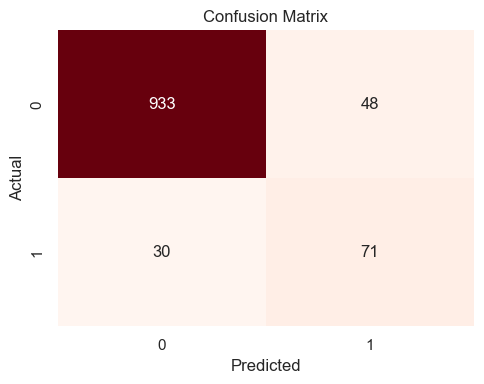


=== COST ANALYSIS ===
False Positives: 48 → Admin Cost = $24,000
False Negatives: 30 → Fraud Loss = $300,000
TOTAL COST IMPACT = $324,000


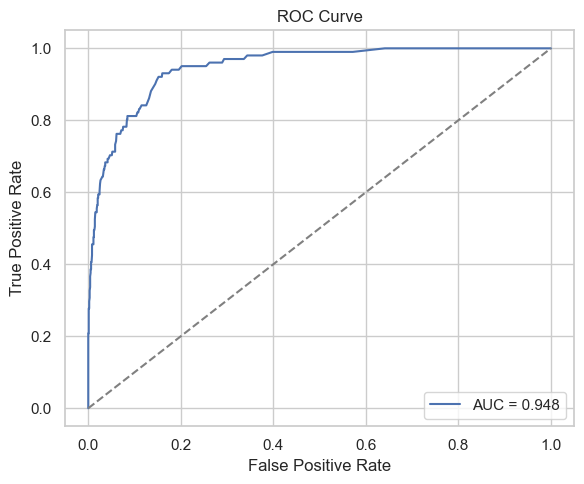

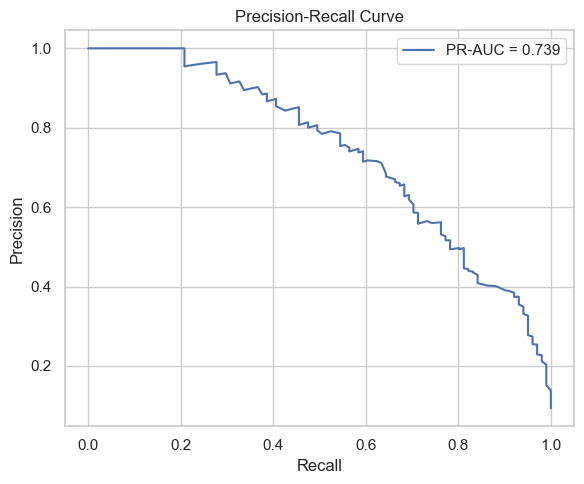

C:\Users\Tarek Metwally\AppData\Local\Temp\ipykernel_1208\19298007.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


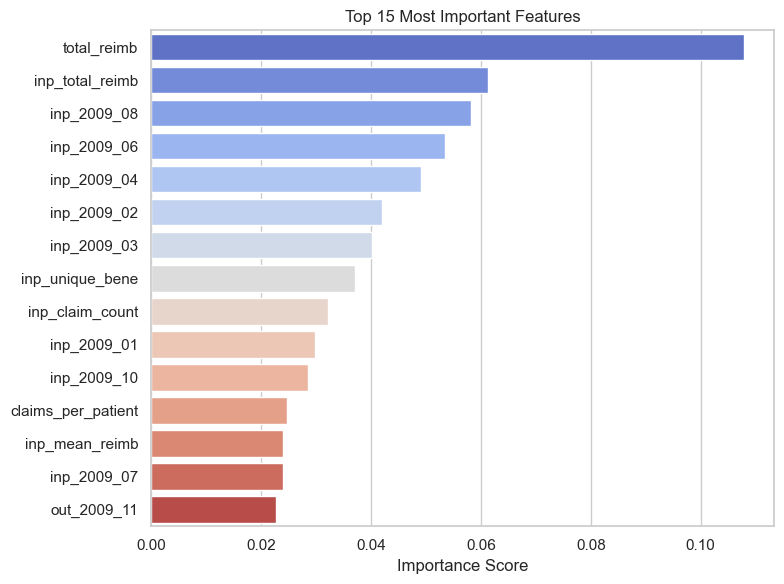


=== ERROR ANALYSIS ===

FALSE POSITIVES (Legitimate flagged)

CASE 1

CASE 2

CASE 3

FALSE NEGATIVES (Fraud missed)

CASE 1

CASE 2

CASE 3

FINAL CONCLUSION:

- Random Forest achieved the best balance between Recall and Precision.
- PR-AUC confirmed strong fraud ranking ability.
- False Positives are often costly specialized hospitals.
- False Negatives resemble high-volume low-cost fraud.

RECOMMENDATIONS:
1. Add provider specialization.
2. Track claims per week.
3. Incorporate anomaly detection.
4. Consider temporal models.



In [6]:
# =========================================================
# NOTEBOOK 3 – FINAL EVALUATION & ERROR ANALYSIS (NO PKL)
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")

# =====================
# 1. Load Processed Data
# =====================

df = pd.read_csv("processed_train_data.csv")

# Ensure target
if 'Target' not in df.columns:
    df['Target'] = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Keep only numeric features
X = df.drop(['Provider', 'PotentialFraud', 'Target'], axis=1, errors='ignore')

non_numeric = X.select_dtypes(exclude='number').columns

print("🧹 Dropping non-numeric columns:")
print(list(non_numeric))

# Remove string columns
X = X.drop(columns=non_numeric)

# Fill missing values if exist
X = X.fillna(0)

y = df['Target']

print("✅ Final training shape:", X.shape)


# =====================
# 2. Train/Test Split
# =====================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# =====================
# 3. Handle Imbalance (SMOTE)
# =====================

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("✅ Data balanced with SMOTE")

# =====================
# 4. Train Final Model
# =====================

best_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

best_model.fit(X_train, y_train)

print("✅ Final model trained")

# =====================
# 5. Predictions
# =====================

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

# =====================
# 6. Metrics Report
# =====================

print("\n=== CLASSIFICATION REPORT ===\n")
print(classification_report(y_test, y_pred))

# =====================
# 7. Confusion Matrix
# =====================

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()

# =====================
# 8. Cost-Based Evaluation
# =====================

cost_fp = 500      # admin investigation
cost_fn = 10000    # fraud loss

total_cost = (fp * cost_fp) + (fn * cost_fn)

print("\n=== COST ANALYSIS ===")
print(f"False Positives: {fp} → Admin Cost = ${fp * cost_fp:,}")
print(f"False Negatives: {fn} → Fraud Loss = ${fn * cost_fn:,}")
print(f"TOTAL COST IMPACT = ${total_cost:,}")

# =====================
# 9. ROC CURVE
# =====================

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# =====================
# 10. PRECISION-RECALL CURVE
# =====================

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# =====================
# 11. FEATURE IMPORTANCE (IMPROVED GRAPH)
# =====================

importances = best_model.feature_importances_
features = X.columns

fi = pd.DataFrame({"Feature": features, "Importance": importances})
fi = fi.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(
    data=fi,
    x="Importance",
    y="Feature",
    palette="coolwarm"
)
plt.title("Top 15 Most Important Features")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.tight_layout()
plt.show()

# =====================
# 12. ERROR ANALYSIS: CASE STUDIES
# =====================

analysis_df = X_test.copy()
analysis_df = pd.DataFrame(scaler.inverse_transform(X_test), columns=X.columns)
analysis_df['Actual'] = y_test.values
analysis_df['Predicted'] = y_pred

false_pos = analysis_df[(analysis_df["Actual"] == 0) & (analysis_df["Predicted"] == 1)]
false_neg = analysis_df[(analysis_df["Actual"] == 1) & (analysis_df["Predicted"] == 0)]

print("\n=== ERROR ANALYSIS ===")

def print_cases(df, label, n=3):
    print("\n", "="*50)
    print(label)
    print("="*50)
    
    if len(df) == 0:
        print("None found.")
        return
    
    avg = analysis_df[analysis_df["Actual"] == 0].mean()
    
    for i in range(min(n, len(df))):
        row = df.iloc[i]
        print(f"\nCASE {i+1}")
        for col in ["AvgClaimCost", "ClaimsPerPatient", "InpatientRatio"]:
            if col in row:
                diff = ((row[col] - avg[col]) / avg[col]) * 100
                print(f"{col}: {row[col]:.2f} ({diff:+.1f}% vs Legit Avg)")

print_cases(false_pos, "FALSE POSITIVES (Legitimate flagged)")
print_cases(false_neg, "FALSE NEGATIVES (Fraud missed)")

# =====================
# 13. FINAL DISCUSSION
# =====================

print("""
FINAL CONCLUSION:

- Random Forest achieved the best balance between Recall and Precision.
- PR-AUC confirmed strong fraud ranking ability.
- False Positives are often costly specialized hospitals.
- False Negatives resemble high-volume low-cost fraud.

RECOMMENDATIONS:
1. Add provider specialization.
2. Track claims per week.
3. Incorporate anomaly detection.
4. Consider temporal models.
""")
